In [1]:
"""Take biowulf produced temporal generalization data stacked from BiowulfWithinStillStack.ipynb
and plot the temporal generalization"""

import os
import matplotlib.pyplot as plt
import numpy as np
top_dir = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data'
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/Figures'
data_dir = os.path.join(top_dir, 'TempGenWithinStill/data')
times_dir = os.path.join(top_dir, 'times')
file_path = os.path.join(data_dir, 'allSubjects_trainTime_data.npy')
file_path_times = os.path.join(times_dir, 'TimesForPlots.npy')
all_subjects_data = np.load(file_path)
times = np.load(file_path_times)

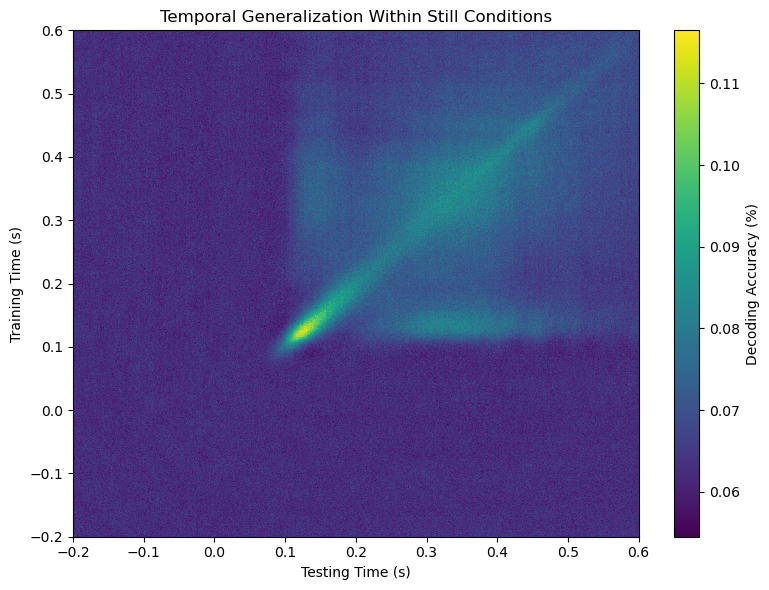

Saved plot to: /Users/sm6511/Desktop/NIH_Experiment/Figures/MeanDecoding_TempGen_Reds.png


In [2]:
import matplotlib.pyplot as plt
import numpy as np
save_path = os.path.join(output_dir, 'MeanDecoding_TempGen_Reds.png')
# all_subjects_data: shape (subjects, train_times, test_times)
mean_accuracy = np.mean(all_subjects_data, axis=0)  # shape: (train_times, test_times)
times = np.load('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy')

# === Plot ===
plt.figure(figsize=(8, 6))
im = plt.imshow(mean_accuracy, 
                origin='lower',   
                aspect='auto', 
                interpolation='nearest', 
                cmap='viridis',
                extent=[times[0], times[-1], times[0], times[-1]])  # ← try 'inferno' or 'magma' too!

plt.colorbar(im, label='Decoding Accuracy (%)')
plt.xlabel('Testing Time (s)')
plt.ylabel('Training Time (s)')
plt.title('Temporal Generalization Within Still Conditions')
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()
plt.close()

print(f"Saved plot to: {save_path}")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from matplotlib.colors import LogNorm

'''Run BF Analysis on tempgen plot '''

# R setup (library paths may need to be adjusted based on environment)
conversion.set_conversion(default_converter + pandas2ri.converter)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")
print("R packages loaded successfully.")

# Parameters
chance = 1 / 16
mu = 0
nullMin = 0.5
nullMax = float('inf')
rscale = 'medium'
start_time = -0.2
end_time = 0.6
n_timepoints = 961
times = np.linspace(start_time, end_time, n_timepoints)

# Paths 
top_dir = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data' #SET TO FILE DIRECTORY
data_dir = os.path.join(top_dir, 'TempGenWithinStill/data')
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/Figures' #SET TO OUTPUT DIRECTORY
os.makedirs(output_dir, exist_ok=True)

# Load all subjects
def load_tempgen_data(data_dir):
    subject_mats = []
    subject_ids = []
    for subj_num in range(1, 21):  # S01–S20
        subj = f"S{subj_num:02d}"
        file_path = os.path.join(data_dir, f"{subj}_trainTime_data.npy")
        if os.path.exists(file_path):
            mat = np.load(file_path)
            subject_mats.append(mat)
            subject_ids.append(subj)
    subject_mats = np.array(subject_mats)  # shape (n_subjects, train, test)
    print(f"Loaded {len(subject_ids)} subjects with shape {subject_mats.shape}")
    return subject_mats, subject_ids

data_all, subject_ids = load_tempgen_data(data_dir)

# --- Compute Bayes Factors matrix ---
def compute_bayes_factors_tempgen(data_all):
    """
    Compute BF for each [train, test] pair across subjects.
    data_all: shape (n_subjects, train_time, test_time)
    """
    n_subjects, n_train, n_test = data_all.shape
    bf_matrix = np.zeros((n_train, n_test))

    # normalize by chance
    normalized = data_all - chance

    print("Computing Bayes Factors")
    for i in range(n_train):
        if i % 100 == 0:
            print(f"Training time {i}/{n_train}")
        for j in range(n_test):
            # Data across subjects for one train/test time pair
            sample_data = normalized[:, i, j]
            df = pd.DataFrame({'x': sample_data})

            with localconverter(ro.default_converter + pandas2ri.converter):
                r_vector = ro.conversion.py2rpy(df['x'])

            result = bayesfactor.ttestBF(
                x=r_vector,
                mu=mu,
                rscale=rscale,
                nullInterval=ro.FloatVector([nullMin, nullMax])
            )

            bf_value = np.array(ro.r['as.vector'](result))[0]
            bf_matrix[i, j] = bf_value

    return bf_matrix

bf_matrix = compute_bayes_factors_tempgen(data_all)

# Compute group mean accuracy 
mean_tempgen = data_all.mean(axis=0)

# Save results   
np.save(os.path.join(data_dir, "BF_matrix.npy"), bf_matrix)



R packages loaded successfully.
Loaded 20 subjects with shape (20, 961, 961)
Computing Bayes Factors
Training time 0/961
Training time 100/961
Training time 200/961
Training time 300/961
Training time 400/961
Training time 500/961
Training time 600/961
Training time 700/961
Training time 800/961
Training time 900/961


Loaded 20 subjects with shape (20, 961, 961)
(961, 961)
[[-2.22717778 -2.07551938 -2.0920621  ... -2.36909763 -3.72889703
  -2.82031782]
 [-3.49540453  0.11108786  0.49009021 ... -1.63754862  0.05556514
  -2.46032081]
 [-2.86342411 -0.99933014  1.01055127 ... -1.29841592  0.73596492
  -1.40994106]
 ...
 [-1.50111845 -0.11948397 -4.31740164 ...  1.8794397   1.67837784
   1.77596519]
 [-2.56877326 -0.63845776 -1.04429374 ...  1.52827229  1.1628592
   0.27138987]
 [-2.91504286 -1.19685672 -2.41880441 ...  1.05151154  1.02455943
   1.50043729]]


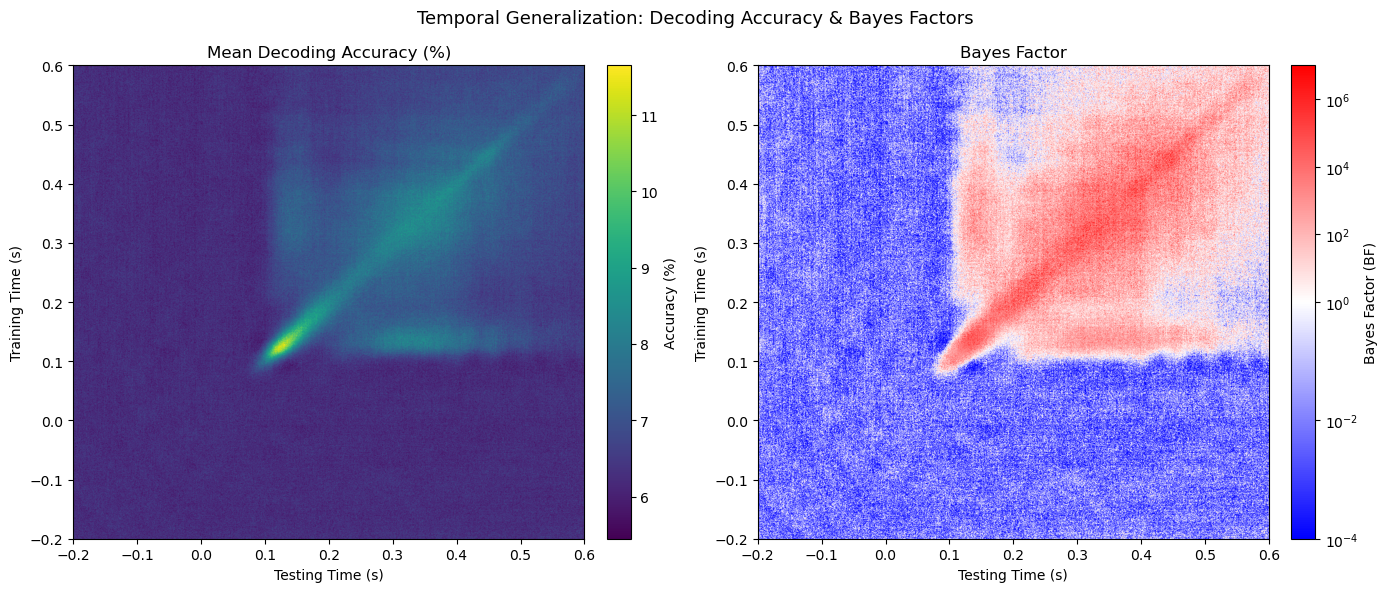

Plot saved to /Users/sm6511/Desktop/NIH_Experiment/Figures/TempGen_BF_Analysis.png


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def load_tempgen_data(data_dir):
    subject_mats = []
    subject_ids = []
    for subj_num in range(1, 21):  # S01–S20
        subj = f"S{subj_num:02d}"
        file_path = os.path.join(data_dir, f"{subj}_trainTime_data.npy")
        if os.path.exists(file_path):
            mat = np.load(file_path)
            subject_mats.append(mat)
            subject_ids.append(subj)
    subject_mats = np.array(subject_mats)  # shape (n_subjects, train, test)
    print(f"Loaded {len(subject_ids)} subjects with shape {subject_mats.shape}")
    return subject_mats, subject_ids

data_all, subject_ids = load_tempgen_data(data_dir)
bf_matrix = np.load(os.path.join(data_dir, "BF_matrix.npy"))
mean_tempgen = data_all.mean(axis=0)

def plot_bf_tempgen(mean_mat, bf_mat, times, save_dir):
    log_bf = np.log10(bf_mat)
    print(log_bf)
    vmin, vmax = -4, 7
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Mean decoding accuracy
    im1 = ax1.imshow(mean_mat * 100, origin='lower', 
                     extent=[times[0], times[-1], times[0], times[-1]],
                     cmap='viridis', aspect='auto')
    ax1.set_title('Mean Decoding Accuracy (%)')
    ax1.set_xlabel('Testing Time (s)')
    ax1.set_ylabel('Training Time (s)')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Accuracy (%)')

    # Bayes Factor
    im2 = ax2.imshow(log_bf, origin='lower', 
                     extent=[times[0], times[-1], times[0], times[-1]],
                     cmap='bwr', norm=norm, aspect='auto')
    ax2.set_title('Bayes Factor')
    ax2.set_xlabel('Testing Time (s)')
    ax2.set_ylabel('Training Time (s)')

    # Custom colorbar labels as 10^x 
    cbar = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    ticks = np.arange(vmin, vmax + 1, 2)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"$10^{{{int(t)}}}$" for t in ticks])
    cbar.set_label('Bayes Factor (BF)', fontsize=10)
    fig.suptitle('Temporal Generalization: Decoding Accuracy & Bayes Factors', fontsize=13)
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'TempGen_BF_Analysis.png')
    # plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    print(f"Plot saved to {save_path}")



plot_bf_tempgen(mean_tempgen, bf_matrix, times, output_dir)

In [3]:
np.shape(mean_accuracy)

(961, 961)

124.167
Peak 1 sample: 389, Peak 2 sample: 635


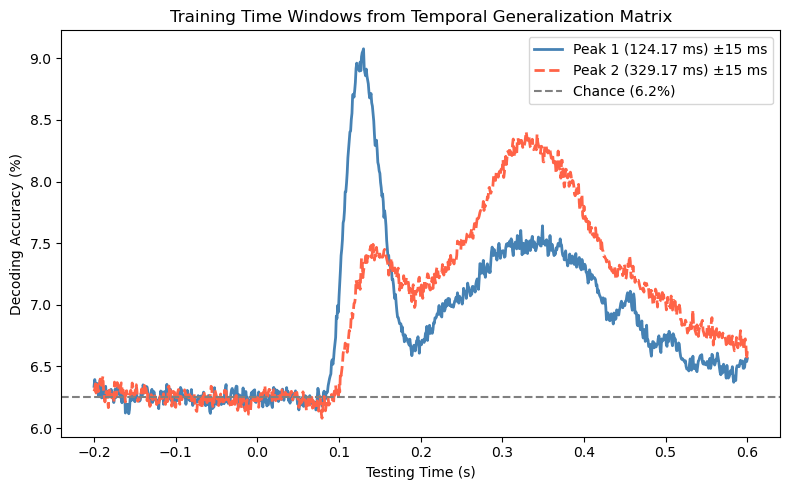

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# --- Helper Function ---
def get_train_window(peak_sample, window_size=36):
    """
    Return a window (start, end) of samples centered on the peak_sample.
    """
    start = max(0, peak_sample - window_size)
    end = peak_sample + window_size
    return start, end

# Paths
output_dir = '/Users/sm6511/Desktop/NIH_Experiment/Figures'
os.makedirs(output_dir, exist_ok=True)

# Load peak time information
df = pd.read_csv('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/LDA-16way Static/Mean/Peak_Times.csv')
row_all = df.loc[df['Subject'] == 'all']
time1_sample = int(row_all['peak1_sample'].values[0])
time2_sample = int(row_all['peak2_sample'].values[0])
time1 = row_all['peak1_time_ms'].values[0]
time2 = row_all['peak2_time_ms'].values[0]
print(time1)

print(f"Peak 1 sample: {time1_sample}, Peak 2 sample: {time2_sample}")

# Compute mean accuracy across subjects
mean_accuracy = np.mean(all_subjects_data, axis=0)  # shape: [train_time, test_time]

# --- Get windows around each peak ---
win1_start, win1_end = get_train_window(time1_sample, window_size=36)
win2_start, win2_end = get_train_window(time2_sample, window_size=36)

# --- Compute mean across window (averaging over training times within the window) ---
line_peak1 = mean_accuracy[win1_start:win1_end, :].mean(axis=0) * 100  # Convert to %
line_peak2 = mean_accuracy[win2_start:win2_end, :].mean(axis=0) * 100  # Convert to %

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(times, line_peak1, color='steelblue', linewidth=2, label=f'Peak 1 ({time1:.2f} ms) ±15 ms')
plt.plot(times, line_peak2, color='tomato', linewidth=2, linestyle='--', label=f'Peak 2 ({time2:.2f} ms) ±15 ms')

# Chance level in %
chance = (1/16) * 100
plt.axhline(chance, color='gray', linestyle='--', label=f'Chance ({chance:.1f}%)')

plt.xlabel('Testing Time (s)')
plt.ylabel('Decoding Accuracy (%)')
plt.title('Training Time Windows from Temporal Generalization Matrix')
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import os

base_path = '/Users/sm6511/Desktop/NIH_Experiment/!Important Data/TempGenWithinStill/data'
subject_ids = [f"S{str(i).zfill(2)}" for i in range(1, 21)]  # adjust number of subjects


train_idx = time1_sample
train_idx2 = time2_sample

all_subjects_line = []

for subj in subject_ids:
    if subj == "S09":  # skip subject 9
        continue
    data = np.load(os.path.join(base_path, f"{subj}_trainTime_data.npy"))  # shape: train_times x test_times
    line = data[train_idx, :]  # extract row for that training time
    all_subjects_line.append(line)

all_subjects_line = np.array(all_subjects_line)  # shape: subjects x test_times
print(all_subjects_line.shape)

all_subjects_line2 = []

for subj in subject_ids:
    if subj == "S09":  # skip subject 9
        continue
    data = np.load(os.path.join(base_path, f"{subj}_trainTime_data.npy"))  # shape: train_times x test_times
    line = data[train_idx2, :]  # extract row for that training time
    all_subjects_line2.append(line)

all_subjects_line2 = np.array(all_subjects_line2)  # shape: subjects x test_times
print(all_subjects_line2.shape)


(19, 961)
(19, 961)


 R packages loaded successfully.


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_57575/3849339135.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


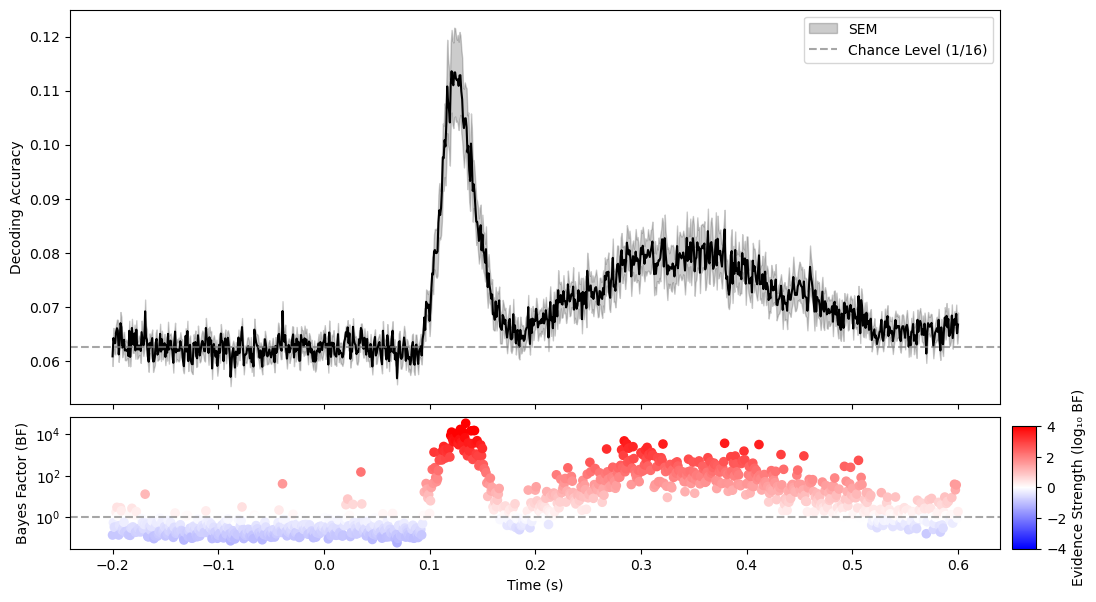

In [6]:
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

#Library path to r (will need to be adjusted for a given environment)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)
#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.")
chance = 1 / 16
mu = 0
nullMin = 0
nullMax = float('inf')
rscale = 'medium'
def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores."""
    normalized = data_2d - chance
    df = pd.DataFrame(normalized)  # <-- wrap numpy array in pandas DataFrame

    bf = []
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])

        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value)

    return np.array(bf)

bf_line = compute_bayes_factors_group(all_subjects_line)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

log_bf = np.log10(bf_line)
times = np.load('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy')

# Colormap setup
cmap = cm.get_cmap('bwr')
max_abs_logbf = 4
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_logbf, vcenter=0, vmax=max_abs_logbf)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 7),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

# Top plot: mean decoding accuracy
sem_scores = all_subjects_line.std(axis=0) / np.sqrt(all_subjects_line.shape[0])
ax1.plot(times, all_subjects_line.mean(axis=0), color='black')
ax1.fill_between(times, all_subjects_line.mean(axis=0) - sem_scores, all_subjects_line.mean(axis=0) + sem_scores,
                 color='black', alpha=0.2, label='SEM')
ax1.axhline(y=1/16, color='gray', linestyle='--', label='Chance Level (1/16)', alpha=.7)
ax1.set_ylabel('Decoding Accuracy')
ax1.legend(loc='upper right')

# Bottom plot: Bayes Factor dots
sc = ax2.scatter(times, bf_line, c=log_bf, cmap=cmap, norm=norm, s=35)
ax2.set_yscale('log')
ax2.set_ylabel('Bayes Factor (BF)')
ax2.axhline(y=1, color='gray', linestyle='--', label='BF = 1', alpha=.7)
ax2.set_xlabel('Time (s)')  # x-axis now in seconds




# Colorbar
pos = ax2.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
sc.set_clim(-max_abs_logbf, max_abs_logbf)
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Evidence Strength (log₁₀ BF)')

plt.subplots_adjust(hspace=0.05)
#save_path = os.path.join(save_dir, 'Group_Mean_Scores_and_BayesFactors.png')
#plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()


 R packages loaded successfully.


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_57575/3455539264.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


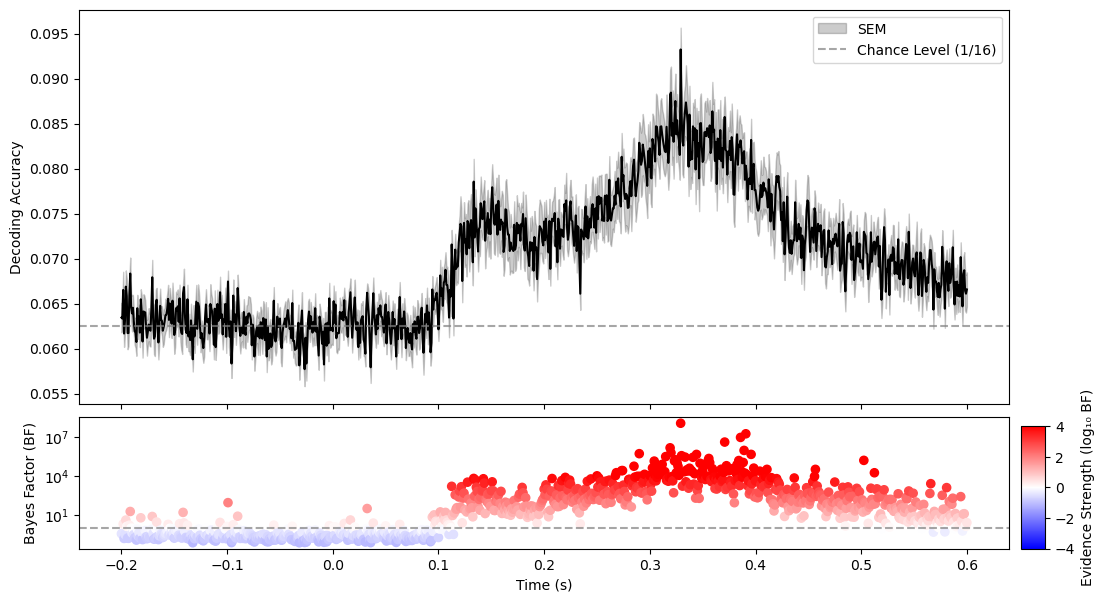

In [7]:
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

#Library path to r (will need to be adjusted for a given environment)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)
#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.")
chance = 1 / 16
mu = 0
nullMin = 0
nullMax = float('inf')
rscale = 'medium'
def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores."""
    normalized = data_2d - chance
    df = pd.DataFrame(normalized)  # <-- wrap numpy array in pandas DataFrame

    bf = []
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])

        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value)

    return np.array(bf)

bf_line = compute_bayes_factors_group(all_subjects_line2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

log_bf = np.log10(bf_line)
times = np.load('/Users/sm6511/Desktop/NIH_Experiment/!Important Data/times/TimesForPlots.npy')

# Colormap setup
cmap = cm.get_cmap('bwr')
max_abs_logbf = 4
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_logbf, vcenter=0, vmax=max_abs_logbf)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 7),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

sem_scores = all_subjects_line2.std(axis=0) / np.sqrt(all_subjects_line2.shape[0])
# Top plot: mean decoding accuracy
ax1.plot(times, all_subjects_line2.mean(axis=0), color='black')
ax1.fill_between(times, all_subjects_line2.mean(axis=0) - sem_scores, all_subjects_line2.mean(axis=0) + sem_scores,
                 color='black', alpha=0.2, label='SEM')
ax1.axhline(y=1/16, color='gray', linestyle='--', label='Chance Level (1/16)', alpha=.7)
ax1.set_ylabel('Decoding Accuracy')
ax1.legend(loc='upper right')

# Bottom plot: Bayes Factor dots
sc = ax2.scatter(times, bf_line, c=log_bf, cmap=cmap, norm=norm, s=35)
ax2.set_yscale('log')
ax2.set_ylabel('Bayes Factor (BF)')
ax2.axhline(y=1, color='gray', linestyle='--', label='BF = 1', alpha=.7)
ax2.set_xlabel('Time (s)')  # x-axis now in seconds




# Colorbar
pos = ax2.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
sc.set_clim(-max_abs_logbf, max_abs_logbf)
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
cbar.set_label('Evidence Strength (log₁₀ BF)')

plt.subplots_adjust(hspace=0.05)
save_path = os.path.join(output_dir, 'Group_Mean_Scores_and_BayesFactors.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()


In [20]:
print(all_subjects_line.shape)

(20, 961)


 R packages loaded successfully.


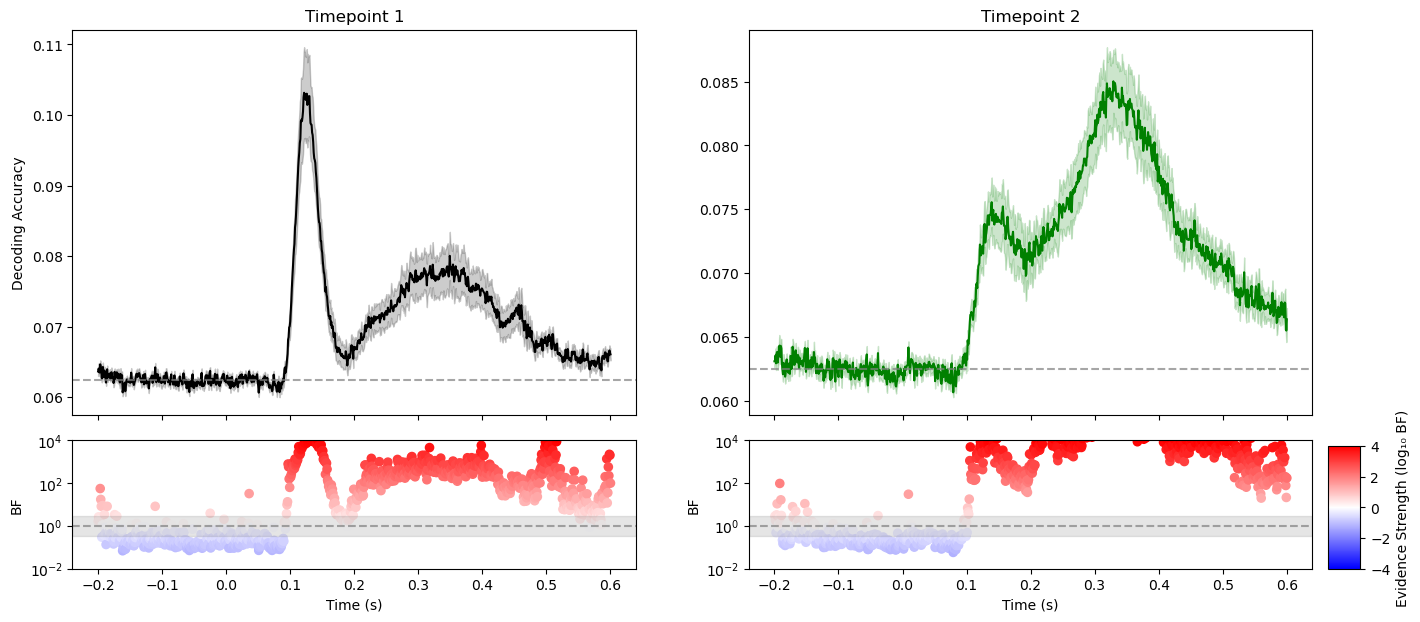

In [34]:
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

#Library path to r (will need to be adjusted for a given environment)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)
#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.")
chance = 1 / 16
mu = 0
nullMin = 0
nullMax = float('inf')
rscale = 'medium'
def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores."""
    normalized = data_2d - chance
    df = pd.DataFrame(normalized)  # <-- wrap numpy array in pandas DataFrame

    bf = []
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])

        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value)

    return np.array(bf)
window_size = 36
half_window = window_size // 2

def extract_window_mean(subj, tp):
    data = np.load(os.path.join(base_path, f"{subj}_trainTime_data.npy"))
    start = max(0, tp - half_window)
    end = min(data.shape[0], tp + half_window)
    return data[start:end, :].mean(axis=0)  # mean across training-time window

all_subjects_line = np.array([extract_window_mean(subj, time1_idx) for subj in subject_ids])
all_subjects_line2 = np.array([extract_window_mean(subj, time2_idx) for subj in subject_ids])

# Compute Bayes factors
bf_line = compute_bayes_factors_group(all_subjects_line)
bf_line2 = compute_bayes_factors_group(all_subjects_line2)
log_bf = np.log10(bf_line)
log_bf2 = np.log10(bf_line2)

# --- Plotting ---
fig, axes = plt.subplots(
    2, 2, figsize=(16, 7),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex='col'
)
ax1, ax2 = axes[0]  # top row: decoding
ax3, ax4 = axes[1]  # bottom row: Bayes factors

# --- Top row: decoding accuracy ---
sem_scores1 = all_subjects_line.std(axis=0) / np.sqrt(all_subjects_line.shape[0])
ax1.plot(times, all_subjects_line.mean(axis=0), color='black')
ax1.fill_between(times,
                 all_subjects_line.mean(axis=0) - sem_scores1,
                 all_subjects_line.mean(axis=0) + sem_scores1,
                 color='black', alpha=0.2)
ax1.axhline(y=1/16, color='gray', linestyle='--', alpha=.7)
ax1.set_ylabel('Decoding Accuracy')
ax1.set_title('Timepoint 1')

sem_scores2 = all_subjects_line2.std(axis=0) / np.sqrt(all_subjects_line2.shape[0])
ax2.plot(times, all_subjects_line2.mean(axis=0), color='green')
ax2.fill_between(times,
                 all_subjects_line2.mean(axis=0) - sem_scores2,
                 all_subjects_line2.mean(axis=0) + sem_scores2,
                 color='green', alpha=0.2)
ax2.axhline(y=1/16, color='gray', linestyle='--', alpha=.7)
ax2.set_title('Timepoint 2')

# --- Bottom row: Bayes factors ---
sc1 = ax3.scatter(times, bf_line, c=log_bf, cmap=cmap, norm=norm, s=35)
ax3.set_yscale('log')
ax3.set_ylabel('BF')
ax3.axhline(1, color='gray', linestyle='--', alpha=.7)
ax3.axhspan(1/3, 3, color='gray', alpha=0.2)
ax3.set_ylim(1e-2, 1e4)
ax3.set_xlabel('Time (s)')

sc2 = ax4.scatter(times, bf_line2, c=log_bf2, cmap=cmap, norm=norm, s=35)
ax4.set_yscale('log')
ax4.set_ylabel('BF')
ax4.axhline(1, color='gray', linestyle='--', alpha=.7)
ax4.axhspan(1/3, 3, color='gray', alpha=0.2)
ax4.set_ylim(1e-2, 1e4)
ax4.set_xlabel('Time (s)')

# --- Colorbar for BF subplot (match ax4 height) ---
pos = ax4.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='vertical')
cbar.set_label('Evidence Strength (log₁₀ BF)')

plt.subplots_adjust(wspace=0.2, hspace=0.1)
save_path = os.path.join(output_dir, 'EXCLud9.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

